In [1]:
import pandas as pd
import numpy as np
import math
import helper
import time
import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score, LeaveOneOut, ShuffleSplit, train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectPercentile, SelectFromModel
import pickle    


In [2]:
# Общая функция для удобного обучения и предсказания на контрольных данных
def get_main_df_for_predict(df_rating_teams_Premium):

# -------- Создание основного ДФ -----------------------------------------------
    # Соединение всех данных в один ДФ
    main = df_rating_teams_Premium

    # удаление не нужных колонок для обучения
    main = main.drop(['match_id', 'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
               'dire_score', 'radiant_name', 'dire_name','league_name'], axis=1)
    main = main.drop(main.loc[:, 'radiant_H1' : 'dire_P5'], axis=1)

    # # Оставляю только важные фичи, убираю из рейтинга команд ело32 и ело64
    main = main.drop(main.loc[:, 'radiant_current_elo32':'radiant_thirtyDayAvg_elo64'], axis=1)
    main = main.drop(main.loc[:, 'dire_current_elo32':'dire_thirtyDayAvg_elo64'], axis=1)
    print (len(main))
# -------- Заполнить или удалить NaN и добаить коллонку с предсказаниями, обучеными ранее -----------------------------------------------       
    # убрать пустые ячейки
    main = main.dropna()
    print(len(main))
#---------- Для рейтинга команд -----------------------------------------------------------
    main['mu_glicko'] = main['radiant_mu_glicko'] -  main['dire_mu_glicko']
    main['rating_glicko'] = main['radiant_rating_glicko'] -  main['dire_rating_glicko']
    main['ratingSevenDaysAgo_glicko'] = main['radiant_ratingSevenDaysAgo_glicko'] -  main['dire_ratingSevenDaysAgo_glicko']
    main['mu_glicko2'] = main['radiant_mu_glicko2'] -  main['dire_mu_glicko2']
    main['phi_glicko2'] = main['radiant_phi_glicko2'] -  main['dire_phi_glicko2'] 
# -------- Убрать лишние колонки -----------------------------------------------  
    main = main.drop(['radiant_sigma_glicko', 
                       'radiant_phi_glicko2', 'dire_phi_glicko2',
                       'radiant_rating_glicko2', 'dire_rating_glicko2', 
                       'radiant_ratingSevenDaysAgo_glicko2', ], axis=1)
    return main

In [3]:
# Необходимые колонки для предсказания по рейтингу команл
['radiant_mu_glicko', 'radiant_rating_glicko', 'radiant_ratingSevenDaysAgo_glicko', 'radiant_mu_glicko2', 
 'dire_mu_glicko', 'dire_rating_glicko', 'dire_ratingSevenDaysAgo_glicko', 'dire_sigma_glicko', 'dire_mu_glicko2', 
 'dire_ratingSevenDaysAgo_glicko2', 'mu_glicko', 'rating_glicko', 'ratingSevenDaysAgo_glicko', 'mu_glicko2',
 'phi_glicko2'] 
'radiant_mu_glicko', 'radiant_rating_glicko',
       'radiant_ratingSevenDaysAgo_glicko', 'radiant_mu_glicko2',
       'dire_mu_glicko', 'dire_sigma_glicko', 'dire_rating_glicko',
       'dire_ratingSevenDaysAgo_glicko', 'dire_mu_glicko2',
       'dire_ratingSevenDaysAgo_glicko2', 'mu_glicko', 'rating_glicko',
       'ratingSevenDaysAgo_glicko', 'mu_glicko2', 'phi_glicko2'

['radiant_mu_glicko',
 'radiant_rating_glicko',
 'radiant_ratingSevenDaysAgo_glicko',
 'radiant_mu_glicko2',
 'dire_mu_glicko',
 'dire_rating_glicko',
 'dire_ratingSevenDaysAgo_glicko',
 'dire_sigma_glicko',
 'dire_mu_glicko2',
 'dire_ratingSevenDaysAgo_glicko2',
 'mu_glicko',
 'rating_glicko',
 'ratingSevenDaysAgo_glicko',
 'mu_glicko2',
 'phi_glicko2']

# Подгрузка всех таблиц с данными по матчям

In [4]:
# дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
df_rating_teams_Premium = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
                                      'PREMIUM on 2012-02-28 to 2018-03-01 (PreDay).csv', index_col=0)

# Создание обучающих и тестовых данных

In [5]:
main = get_main_df_for_predict(df_rating_teams_Premium, 
                              )

3602
3602


In [6]:
# сделать обучающие данные и ответы
X = main.drop(['radiant_win'], axis=1)
y = main['radiant_win']
#-------------------------------------

# ---------------------------------------
# СДЕЛАТЬ 1 или 0 вместо true false
y = y.astype(int)

# деление на тестовые и обучающую выборку
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
X_train.columns

Index(['radiant_mu_glicko', 'radiant_rating_glicko',
       'radiant_ratingSevenDaysAgo_glicko', 'radiant_mu_glicko2',
       'dire_mu_glicko', 'dire_rating_glicko',
       'dire_ratingSevenDaysAgo_glicko', 'dire_sigma_glicko',
       'dire_mu_glicko2', 'dire_ratingSevenDaysAgo_glicko2', 'mu_glicko',
       'rating_glicko', 'ratingSevenDaysAgo_glicko', 'mu_glicko2',
       'phi_glicko2'],
      dtype='object')

In [12]:
test_gb = pickle.load(open('Xgboost_model_predict_rating_teams_without_elo.sav', 'rb'))
test_gb.predict_proba(X)

array([[ 0.12339282,  0.87660718],
       [ 0.58705056,  0.41294941],
       [ 0.14039558,  0.85960442],
       ..., 
       [ 0.30269611,  0.69730389],
       [ 0.53815383,  0.46184617],
       [ 0.51461458,  0.48538545]], dtype=float32)

In [13]:
print(classification_report(y_test, test_gb.predict(X_test), target_names=['dire_win', 'radiant_win']))

gb_auc = metrics.roc_auc_score(y_test, test_gb.predict_proba(X_test)[:,1])
print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc))

             precision    recall  f1-score   support

   dire_win       0.70      0.63      0.66       436
radiant_win       0.68      0.74      0.71       465

avg / total       0.69      0.69      0.69       901

AUC для градиентного бустинга - 0.744


# Обучение

In [8]:
%%time
# ДАННЫЕ ПО HEAD-TO-HEAD ДЛЯ ВСЕХ ПАТЧЕЙ ДО ПРЕДЫДУЩЕГО ДНЯ МАТЧЯ
import xgboost as xgb
# fit model no training data
XGB = xgb.XGBClassifier()
XGB.fit(X_train, y_train)
print(classification_report(y_test, XGB.predict(X_test), target_names=['dire_win', 'radiant_win']))

gb_auc = metrics.roc_auc_score(y_test, XGB.predict_proba(X_test)[:,1])
print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc))

             precision    recall  f1-score   support

   dire_win       0.70      0.63      0.66       436
radiant_win       0.68      0.74      0.71       465

avg / total       0.69      0.69      0.69       901

AUC для градиентного бустинга - 0.744
Wall time: 235 ms


In [ ]:
             precision    recall  f1-score   support

   dire_win       0.70      0.63      0.66       436
radiant_win       0.68      0.74      0.71       465

avg / total       0.69      0.69      0.69       901

AUC для градиентного бустинга - 0.744
Wall time: 123 ms

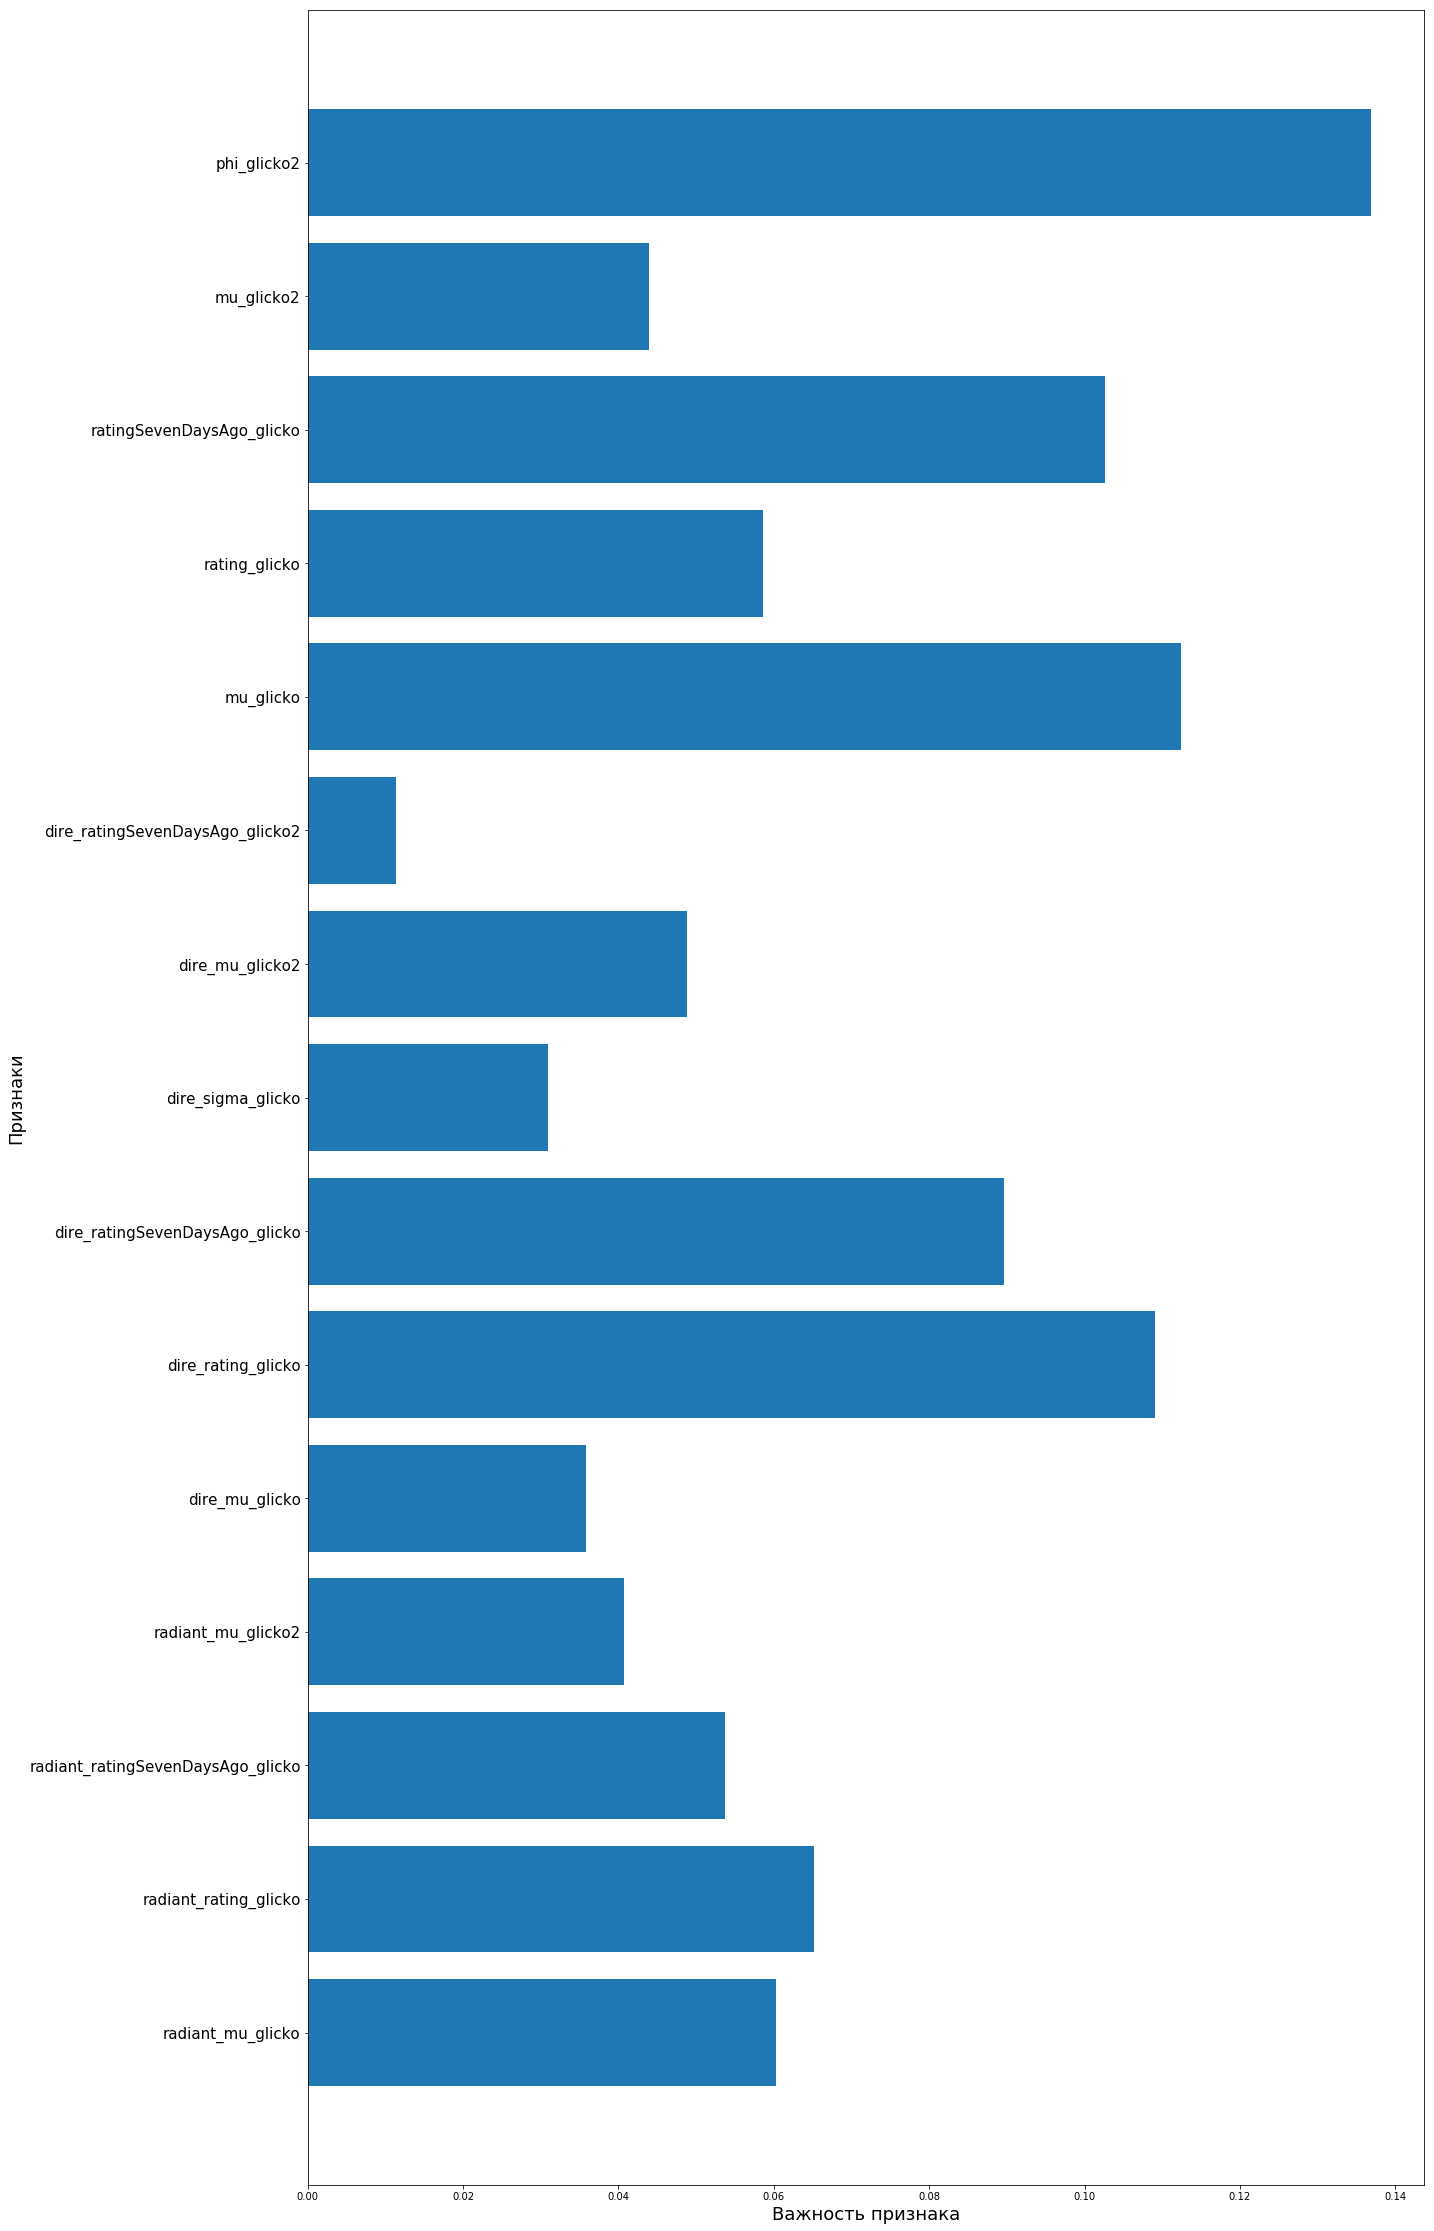

In [9]:
# важность признаков в бустинге

n_features = X_train.shape[1]

plt.figure(figsize=(20,40))
plt.barh(range(n_features), XGB.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns, fontsize=15)
plt.xlabel('Важность признака', fontsize=18)
plt.ylabel('Признаки', fontsize=18)
plt.show()

In [10]:
# save the model to disk
filename = 'Xgboost_model_predict_rating_teams.sav'
pickle.dump(XGB, open(filename, 'wb'))

In [42]:
# Создать и сохранить фичу с предсказаниями по алгоритму, обученому на рейтинге команд
df_pedict_for_rating_teams = pd.DataFrame(XGB.predict_proba(X)[:,1:], columns=['Predict'])
df_pedict_for_rating_teams['match_id'] = df_rating_teams_Premium['match_id'].reset_index().drop('index', axis=1)
df_pedict_for_rating_teams.to_csv('../tabel/table from Datdota/Rating teams/'+
                           'Predict for rating teams on 2012-02-28 to 2018-03-01.csv')

In [15]:
# test_gb = pickle.load(open('Xgboost_model_predict_rating_teams', 'rb'))
# test_gb.score(X_test, y_test)

# Решетчатый поиск на Gradient Bosting

In [115]:
%%time
# Праметры GB
# param_grid = {'n_estimators': [25, 50, 100, 150], 'max_depth': [10, 25, 50, 100],
#               'max_features': [50, 100, 200, 300]}
param_grid = {'n_estimators': [100], 'max_depth': [10],
              'max_features': [30]}
grid_search_GB = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=-1)

grid_search_GB.fit(X_train,y_train)


print("Наилучшие значения параметров: {}".format(grid_search_GB.best_params_))
print('----------------------------------------------------------------------')
print(classification_report(y_test, grid_search_GB.predict(X_test), target_names=['dire_win', 'radiant_win']))

# Проверка на новых данных

In [43]:
# дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
df_rating_teams_Premium_contr = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
                                      'PREMIUM on 2018-03-01 to 2018-04-08 (PreDay).csv', index_col=0)

In [44]:
# pd.set_option('display.max_columns', 500)
contr = get_main_df_for_predict(df_rating_teams_Premium_contr)

451
451


In [45]:
# Создание контрольной выборки
# Cделать обучающие данные и ответы
X_contr = contr.drop(['radiant_win'], axis=1)
y_contr = contr['radiant_win']

# СДЕЛАТЬ 1 или 0 вместо true false
y_contr = y_contr.astype(int)
X_contr.columns

Index(['radiant_mu_glicko', 'radiant_rating_glicko',
       'radiant_ratingSevenDaysAgo_glicko', 'radiant_mu_glicko2',
       'dire_mu_glicko', 'dire_rating_glicko',
       'dire_ratingSevenDaysAgo_glicko', 'dire_sigma_glicko',
       'dire_mu_glicko2', 'dire_ratingSevenDaysAgo_glicko2', 'mu_glicko',
       'rating_glicko', 'ratingSevenDaysAgo_glicko', 'mu_glicko2',
       'phi_glicko2'],
      dtype='object')

In [46]:
print(classification_report(y_contr, XGB.predict(X_contr), target_names=['dire_win', 'radiant_win']))
gb_auc = metrics.roc_auc_score(y_contr, XGB.predict_proba(X_contr)[:,1])
print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc))

             precision    recall  f1-score   support

   dire_win       0.57      0.52      0.54       188
radiant_win       0.68      0.72      0.70       263

avg / total       0.63      0.64      0.63       451

AUC для градиентного бустинга - 0.684


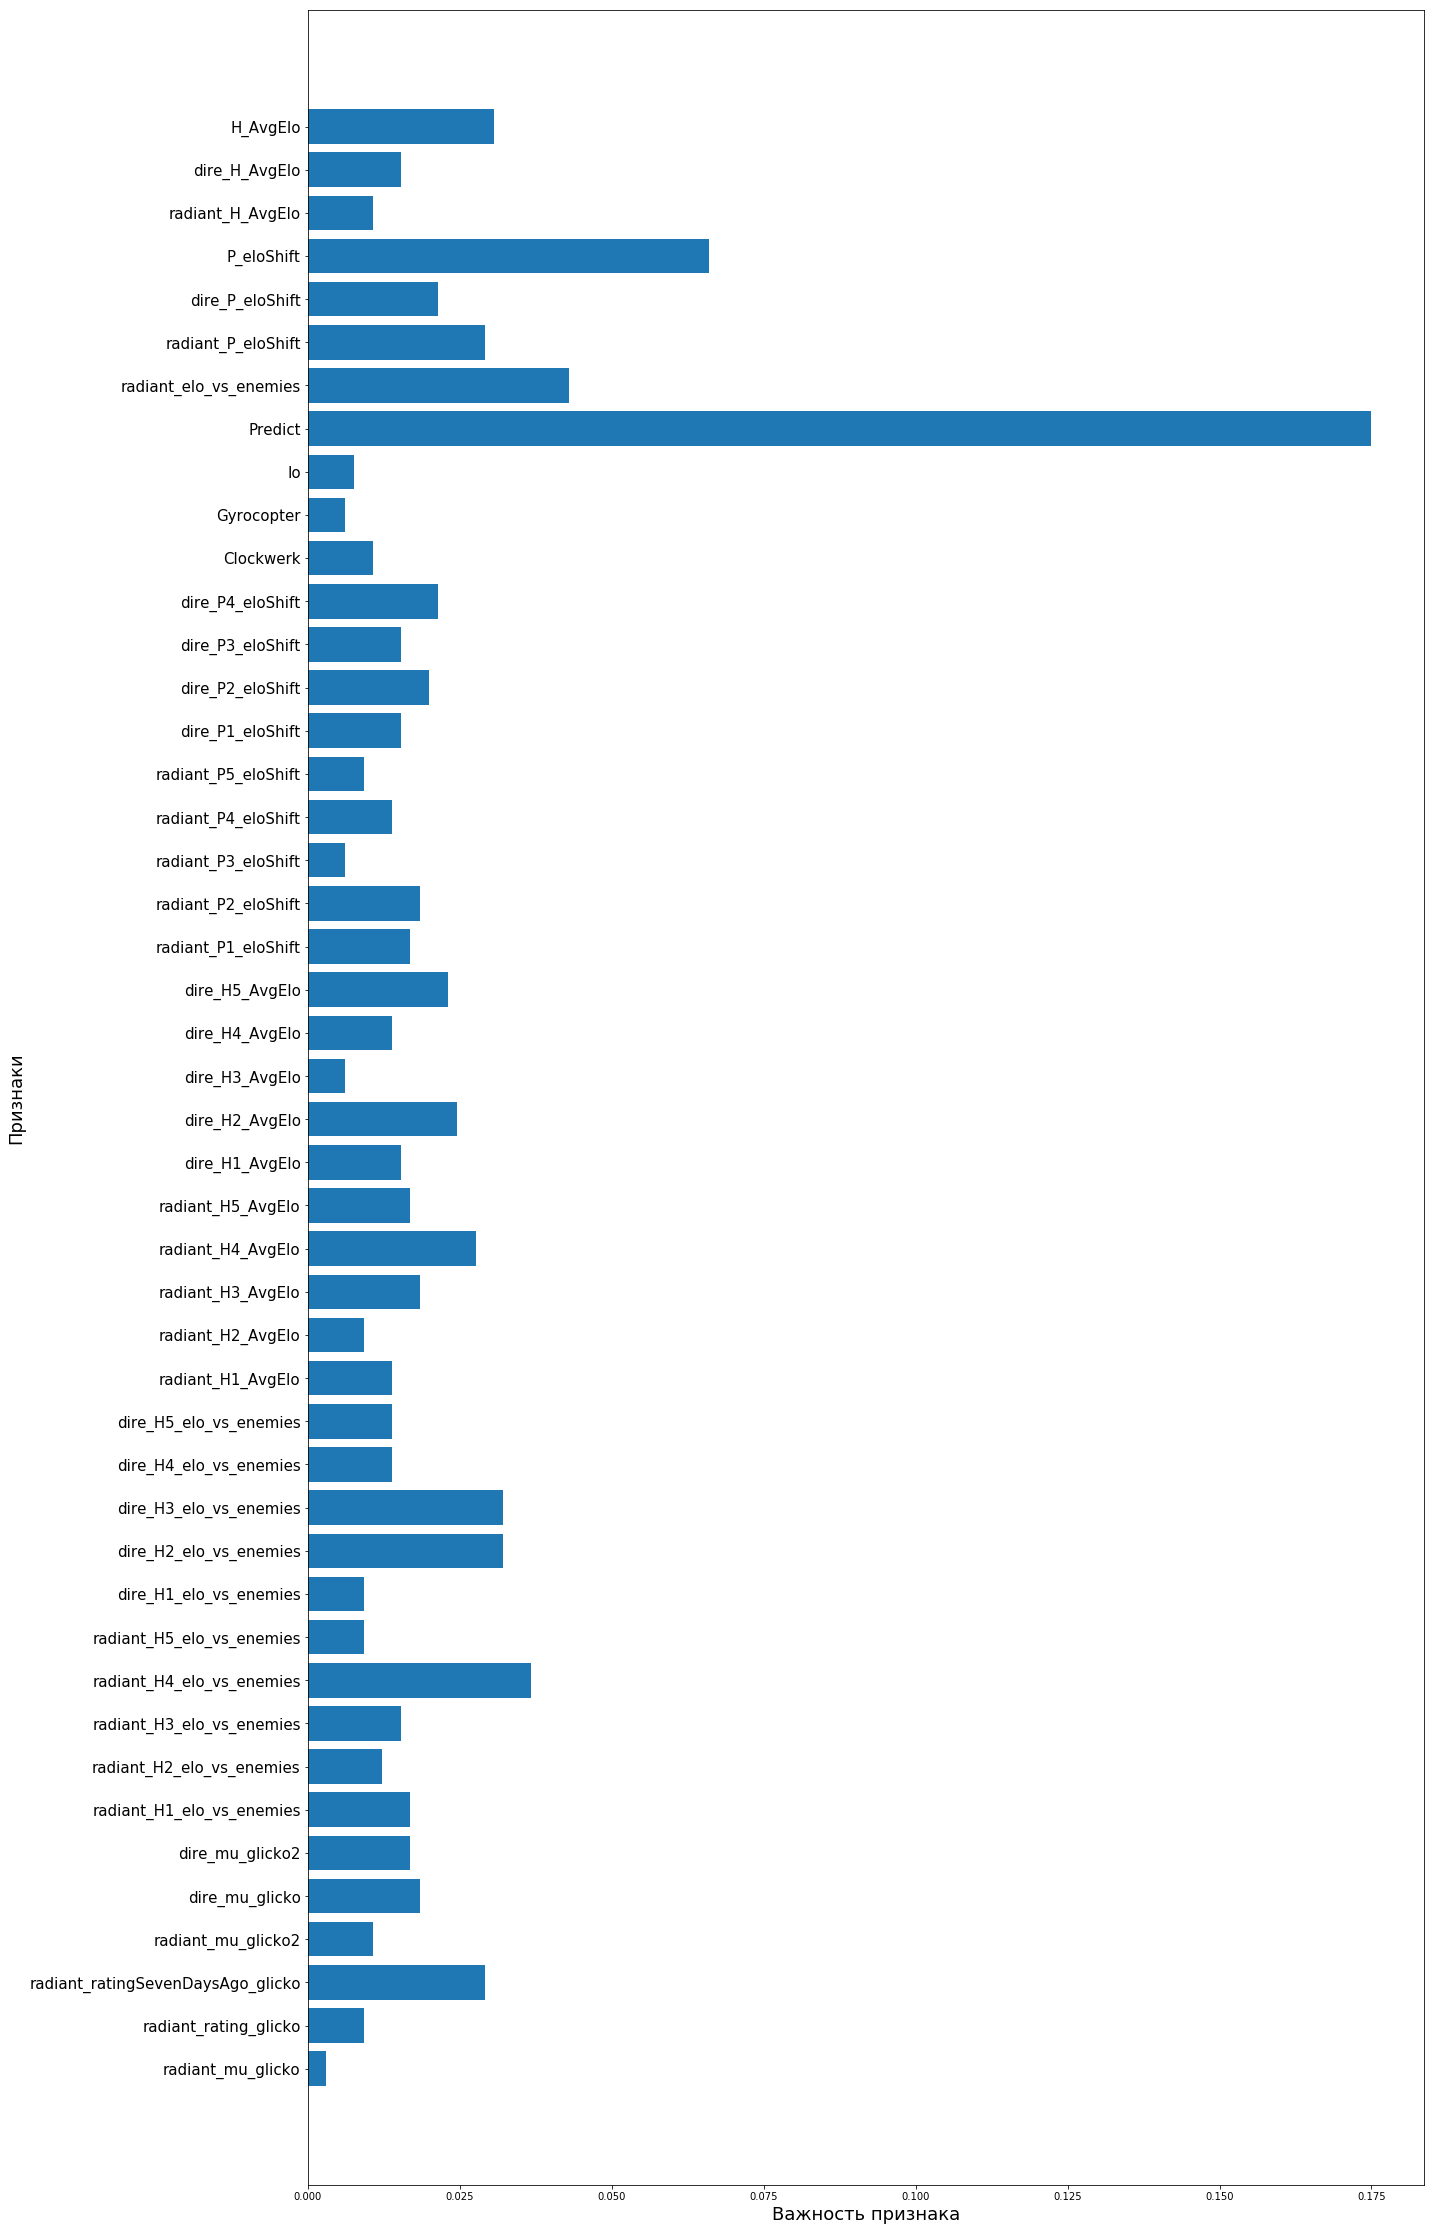

In [38]:
# важность признаков в бустинге

n_features = X_contr.shape[1]

plt.figure(figsize=(20,40))
plt.barh(range(n_features), XGB.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_contr.columns, fontsize=15)
plt.xlabel('Важность признака', fontsize=18)
plt.ylabel('Признаки', fontsize=18)
plt.show()

In [47]:
# Создать и сохранить фичу с предсказаниями по алгоритму, обученому на рейтинге команд
df_pedict_for_rating_teams = pd.DataFrame(test_gb.predict_proba(X_contr)[:,1:], columns=['Predict'])
df_pedict_for_rating_teams['match_id'] = df_rating_teams_Premium_contr['match_id'].reset_index().drop('index', axis=1)
df_pedict_for_rating_teams.to_csv('../tabel/table from Datdota/Rating teams/'+
                           'Predict for rating teams on 2018-03-01 to 2018-04-08.csv')